In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from scipy.fftpack import idct
import lib
np.random.seed(666)

Variable initialization

In [2]:
N = 32 # signal dimension
M = 32 # number of atoms in the span (for basis M = N)

Generate the 1D-DCT basis

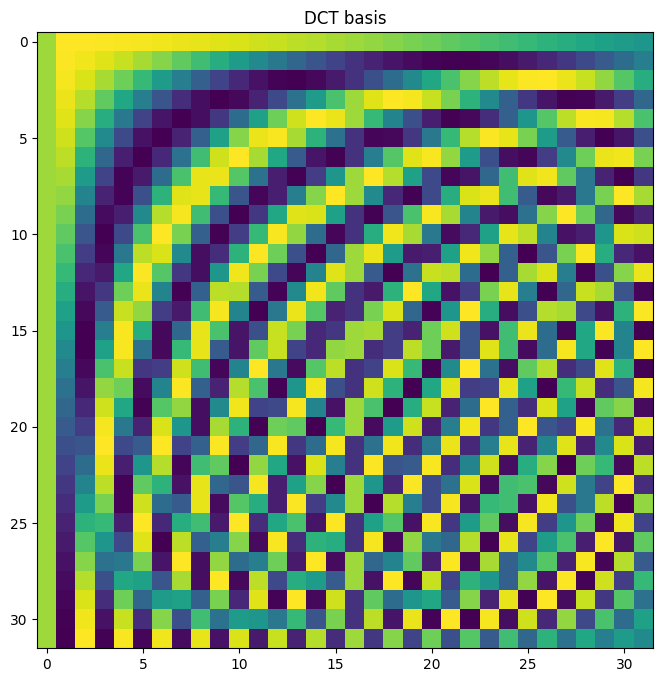

In [3]:
D = lib.dct_matrix(M)

plt.figure(figsize=(8,8))
plt.imshow(D)
plt.title('DCT basis');

# Sparsity w.r.t orthonormal dictionary D

In this section you will perform denoising of a signal that is *sparse* w.r.t. the orthornormal dictionary $D\in\mathbb{R}^{N\times N}$, i.e., the 1D-DCT dictionary.

At first, generate a vector $x_{orig}\in\mathbb{R}^N$ that is $L$-sparse, i.e. $\|x_{orig}\|_0 = L$. Use this coefficient vector $x_{orig}$, generate a noise-free signal $y\in\mathbb{R}^N$ as $y=Dx_{orig}$, and add some Gaussian noise to obtain $s = y + \eta$.

Perform the DCT denoising on the noisy signal $s$ to recover $\hat y$. Use the Hard Thresholding operator that keeps only the largest $L$ coefficients and evaluate the denoising performance


Set the sparsity level $L$

In [4]:
L = 3

Randomly define the coefficients of a sparse representation $x$ (make sure the nonzero coefficients are sufficiently large)

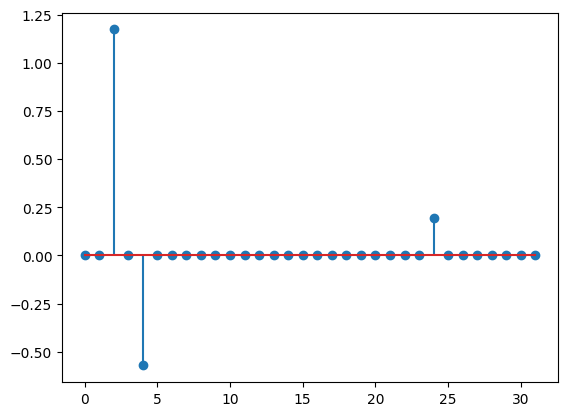

In [5]:
x_orig = lib.Lsparse(N, L)
plt.stem(x_orig);

Synthetize the corresponding signal in the signal domain and add noise


In [6]:
y = D @ x_orig
s = y + np.random.randn(y.size) * 0.1

Plot the sparse signal

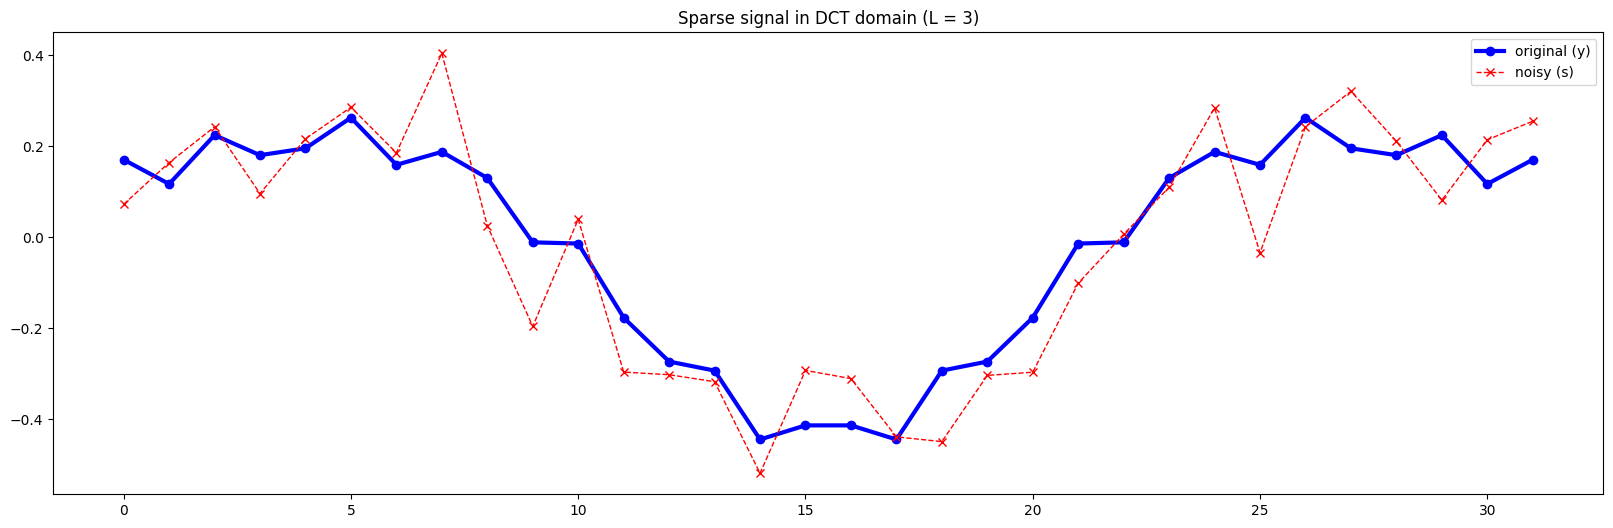

In [7]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(20,6))
plt.plot(y, 'b-o', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original (y)', 'noisy (s)']);

### Implement the DCT denoising

This is expected to be very effective on $s$!

**Analysis**: compute the coefficients w.r.t. $D$

In [8]:
x = D.T @ s

**Hard Thresholding**: keep only the $L$ largest coefficients (absolute value)

In [9]:
x_hat = x.copy()
x_hat[np.argsort(x_hat)[:-L]] = 0

**Synthesis**: invert the transform

In [10]:
s_hat = D @ x_hat

Plot the results:
- are the denoising performance good?
- are the original coefficients $x_{orig}$ recovered by $\hat x$?

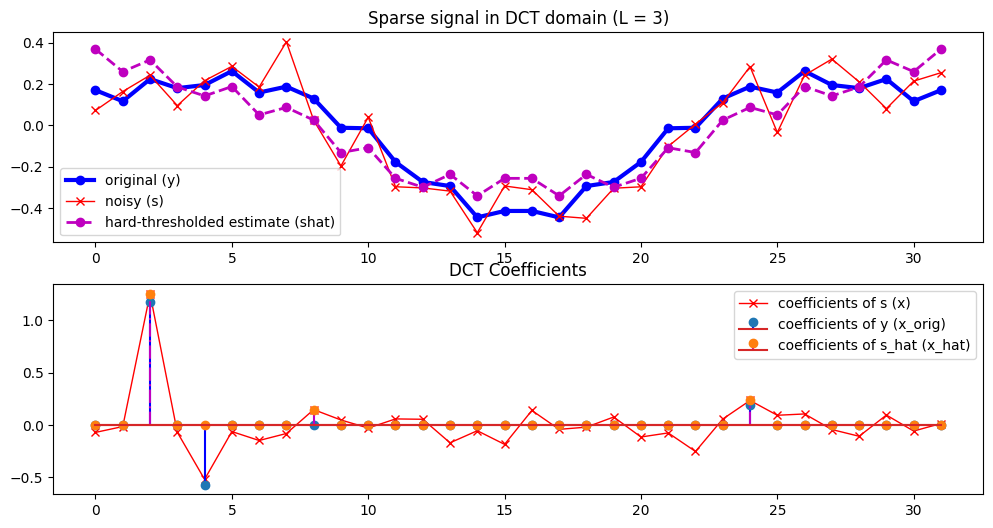

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(y, 'b-o', linewidth=LN_WDT+1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT-1)
ax[0].plot(s_hat, 'm--o', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (y)', 'noisy (s)', 'hard-thresholded estimate (shat)'])



ax[1].plot(x, 'r-x', linewidth=LN_WDT-1)
ax[1].stem(x_orig, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_hat, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s (x)', 'coefficients of y (x_orig)', 'coefficients of s_hat (x_hat)']);


# Sparsity w.r.t redundant dictionary

In this section you will perform the same denoising as in the previous section with the only difference that the signal $s = y + \eta$ that you will generate is sparse w.r.t. a redoundant dictionary $A=[C, D] \in\mathbb{R}^{M \times N}$, where $C\in\mathbb{M\times M}$ is the matrix representity the canonical basis, and $D\in\mathbb{M\times M}$ is the usual 1D-DCT matrix. Therefore $A$ is a rectangular matrix, since $M < N$.

To generate signals that are sparse w.r.t. $A=[C, D]$, at first generate a signal $y$ that is $L-1$ sparse w.r.t. $D$ as you have done in the previous section. Then, add a spike to $y$ that is sparse w.r.t. $A$. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise.

Generate the standard orthonormal basis

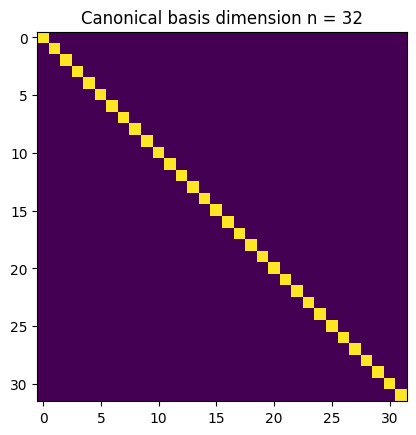

In [12]:
C = np.eye(M)

plt.figure(5)
plt.imshow(C)
plt.title(f'Canonical basis dimension n = {M}');



Generate a signal that is sparse w.r.t. D

In [13]:
x_orig = lib.Lsparse(N, L)
y = D @ x_orig

Randomly place a spike in the first 20 samples of $y$


In [14]:
# choose spike location
spikeLocation = np.random.choice(20, 1).item()
# modify the signal intensity at spikeLocation
# update y
y[spikeLocation] = 10

Add noise to the signal

In [15]:
s = y + np.random.randn(y.size) * 0.2

Perform hard thresholding by keeping the largest $L$ coefficients w.r.t. $D$ (not $A$!)

In [16]:
# analysis: compute the coefficients w.r.t. D
x = D.T @ s

# keep only the L largest coefficients (absolute value)
x_hat = x.copy()
x_hat[np.argsort(np.abs(x_hat))[:-L]] = 0

# invert the transformation
s_hat = D @ x_hat

Plot the results and compare them to the one obtained in the previous section.

Is the signal $s$ denoised properly?

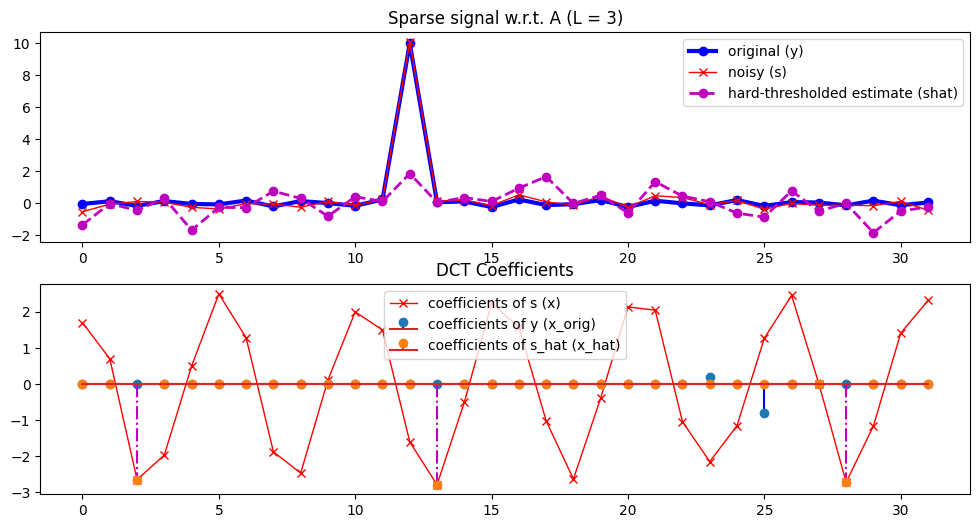

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(y, 'b-o', linewidth=LN_WDT+1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT-1)
ax[0].plot(s_hat, 'm--o', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t. A (L = {L:.0f})')
ax[0].legend(['original (y)', 'noisy (s)', 'hard-thresholded estimate (shat)'])


ax[1].plot(x, 'r-x', linewidth=LN_WDT-1)
ax[1].stem(x_orig, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_hat, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s (x)', 'coefficients of y (x_orig)', 'coefficients of s_hat (x_hat)']);

## Tichonov Regularization


Compute the representation w.r.t. $A = [C, D]$ using Tichonov's regularization (try differente value for $\lambda$)

In [18]:
lmbda = 0.2
A = np.concatenate([C, D], axis=1)
x_hat_tic = np.linalg.inv(A.T @ A + np.eye(A.shape[1]) * lmbda) @ A.T @ s
s_hat_tic = A @ x_hat_tic

Show the results

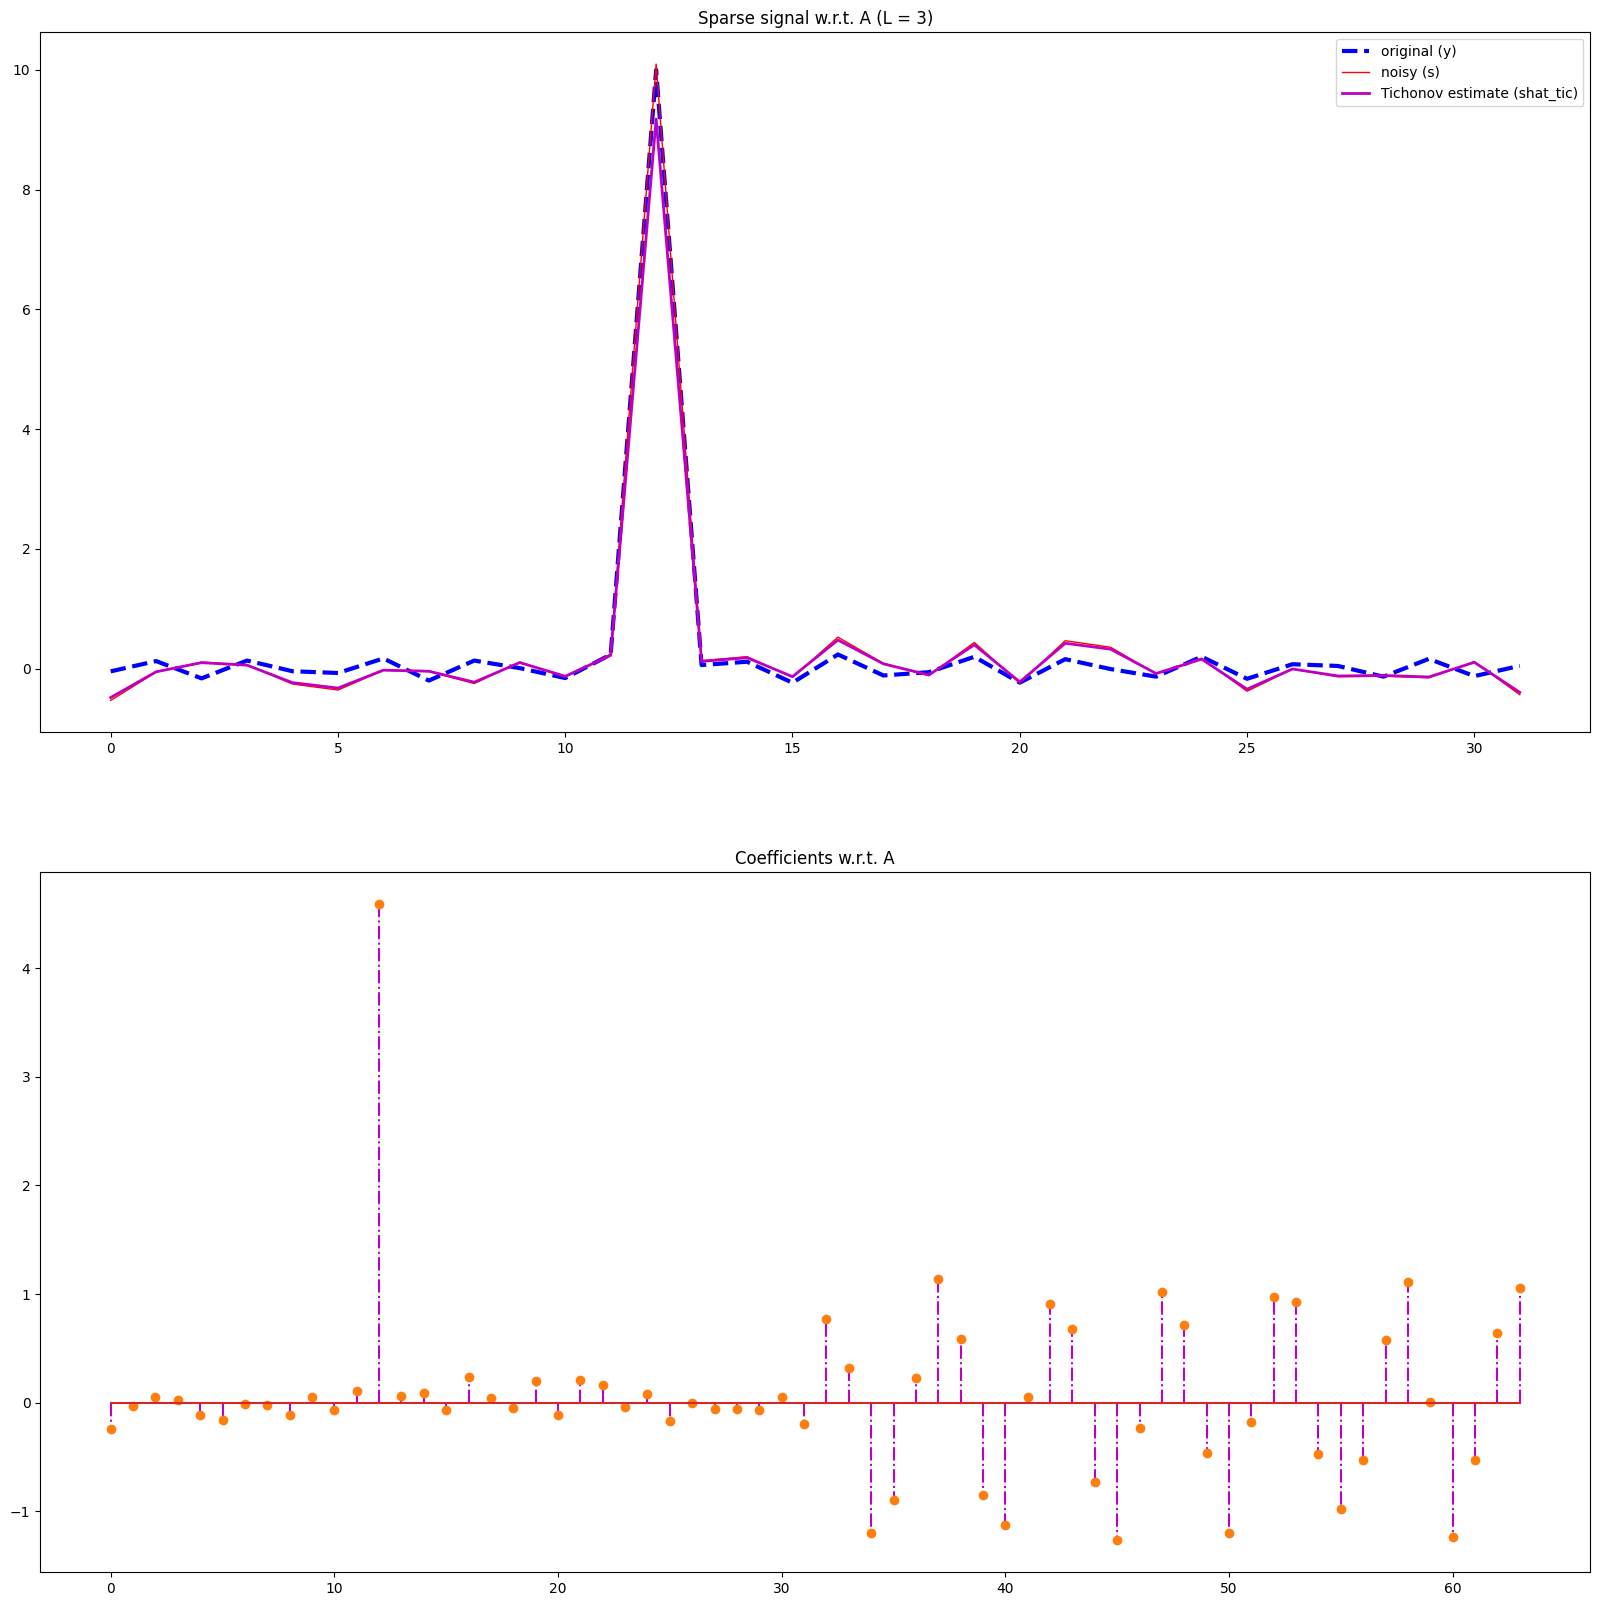

In [19]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.flatten()
ax[0].plot(y, 'b--', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_tic, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t. A (L = {L:.0f})')
ax[0].legend(['original (y)', 'noisy (s)', 'Tichonov estimate (shat_tic)'])

ax[1].stem(x_hat_tic, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients w.r.t. A');